<a href="https://colab.research.google.com/github/renan-estatistica/notebooksAulaRedesNeuraisInpe/blob/main/Projeto_2_Redes_Para_Problemas_N%C3%A3o_Supervisionados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para a primeira base iremos abordar a predição do fluxo crítico de calor ou CHF (*Critical Heat Flux*). Apesar de ser um conjunto de dados pequeno com poucas variáveis e observações, estou estudando o problema da predição do chf no meu mestrado.
Os problemas relacionados à estimação do CHF estão relacionados a transferência de calor, máquina de calor, entre outros.
O CHF pode ser considerado como o limite térmico de um fenomeno onde a ocorrência da mudança de fase durante o aquecimento o que pode gerar uma queda repentina na eficiência da transferência de calor o que pode causar um superaquecimento na superfície aquecida. 
Um exemplo é um tubo sendo e água como líquido refrigerante, ao aquecer o tubo e o mesmo alcançar o limite do chf bolhas começam a se formar ao redor do tubo formando uma "camada" de ar entre o tubo e a água reduzindo a capacidade de transferência do calor do tubo para a água o que causa um superaquecimento que pode derreter o tubo dependendo do material utilizado.
Um exemplo do comportamento do fluxo de calor ao longo da variação da temperatura é apresentado abaixo juntamente com o o ponto **E** representando o momento em que o fluxo apresenta seu limite juntamente com a temperatura:

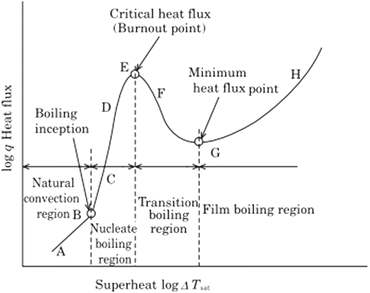



Os dados utilizados é um compilado de vários exprimentos realizados por diferentes autores onde temos observadas diversas variáveis relacionadas aos experimentos realizados. Localização da base no kaggle: 

## Limpeza e Análise Descritiva dos Dados

In [ ]:
!pip install MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for miniSom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=ae8a5f5de595e66f703ce6b76ae1aebc8d206efbda1359ba65ace1d46d4483f4
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built miniSom


In [ ]:
from minisom import MiniSom
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [27]:
dados_chf = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")

In [28]:
# realizando a limpeza dos dados iremos remover as informacoes de ID e autor pois estas nao comtribuem para a modelagem

dados_chf.drop(labels = ["id","author"], axis = 1, inplace = True)

In [29]:
dados_chf.head()

,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [31]:
dados_chf.shape

(1865, 8)

In [32]:
# renomeando as colunas para formatacao code friendly

dados_chf.columns = ["geometry","pressure","mass_flux","x_e_out","d_e","d_h","lenght","chf_exp"]

In [33]:
dados_chf.columns.values

array(['geometry', 'pressure', 'mass_flux', 'x_e_out', 'd_e', 'd_h',
       'lenght', 'chf_exp'], dtype=object)

In [34]:
# iremos remover a variavel categorica da analise
geometry = dados_chf.geometry
dados_chf.drop(columns=["geometry"],inplace = True)

In [35]:
dados_chf.head()

,pressure,mass_flux,x_e_out,d_e,d_h,lenght,chf_exp
0,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [36]:
# normalizando os dados

max_treino = dados_chf.max()
min_treino = dados_chf.min()
x_normalizado = (dados_chf-min_treino)/(max_treino-min_treino)



In [37]:
x_normalizado.shape

(1865, 7)

In [38]:
x_np = x_normalizado.to_numpy()

In [40]:
x_np

array([[0.01409135, 0.70219436, 0.69409302, ..., 0.01680672, 0.02962475,
        0.56756757],
       [0.01020408, 0.84012539, 0.73459543, ..., 0.01680672, 0.02962475,
        0.52972973],
       [0.0111759 , 0.53918495, 0.75288978, ..., 0.01680672, 0.02962475,
        0.35135135],
       ...,
       [0.04421769, 0.2507837 , 0.77892054, ..., 1.        , 0.        ,
        0.54054054],
       [0.04421769, 0.2507837 , 0.76899973, ..., 1.        , 0.        ,
        0.54594595],
       [0.04421769, 0.2507837 , 0.74934013, ..., 1.        , 0.        ,
        0.57837838]])

In [77]:
som = MiniSom(2, 1, 7, sigma=0.3, learning_rate=0.4)
som.train(x_np, 500) # trains the SOM with 100 iterations

In [79]:
winners_list = []
for i in range(len(x_np)):
  winner = som.winner(x_np[i])
  winners_list.append(winner)

In [80]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_np]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (5,1))

In [81]:
np.unique(x_np)

array([0.00000000e+00, 8.40336134e-04, 2.73972603e-03, ...,
       9.94858934e-01, 9.98244514e-01, 1.00000000e+00])

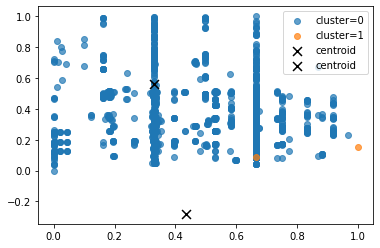

In [82]:
%matplotlib inline
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(x_np[cluster_index == c, 0],
                x_np[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();